In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import random
from tqdm import tqdm

# print directory
import os
print(os.getcwd())
os.chdir("../..")
print(os.getcwd())

from src.models.sparse_autoencoder import *
from src.models.autoencoder import *
from src.functions.ae_training import *
from src.visualization.plotting import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set a random seed
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_dir = '/Users/vschuste/Documents/work/data/simulation/'

/opt/anaconda3/envs/sc_mechinterp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/vschuste/Documents/work_KU/projects/interpreting_omics_models/02_experiments/simulation
/Users/vschuste/Documents/work_KU/projects/interpreting_omics_models


In [2]:
n_samples = 10000
latent_dim = 150
model_depth = 2
complexity = 'high'
dropout_rate = 0.1

baseline_val_loss = 22

In [3]:
#for seed in range(10):
for seed in range(1):
    if seed == 0:
        rna_counts = torch.load(data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed), weights_only=False)
    else:
        temp = torch.load(data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed), weights_only=False)
        rna_counts = torch.cat((rna_counts, temp), dim=0)
# now subsample the data if necessary
if n_samples < rna_counts.shape[0]:
    rna_counts = rna_counts[:n_samples]
rna_counts = rna_counts.to(device)
n_samples_validation = int(n_samples*0.1)
print('Data loaded.')
print('Data shape:', rna_counts.shape)

Data loaded.
Data shape: torch.Size([10000, 20000])


## Train

### basic GAN with MSE losses

100%|██████████| 2000/2000 [32:36<00:00,  1.02it/s]


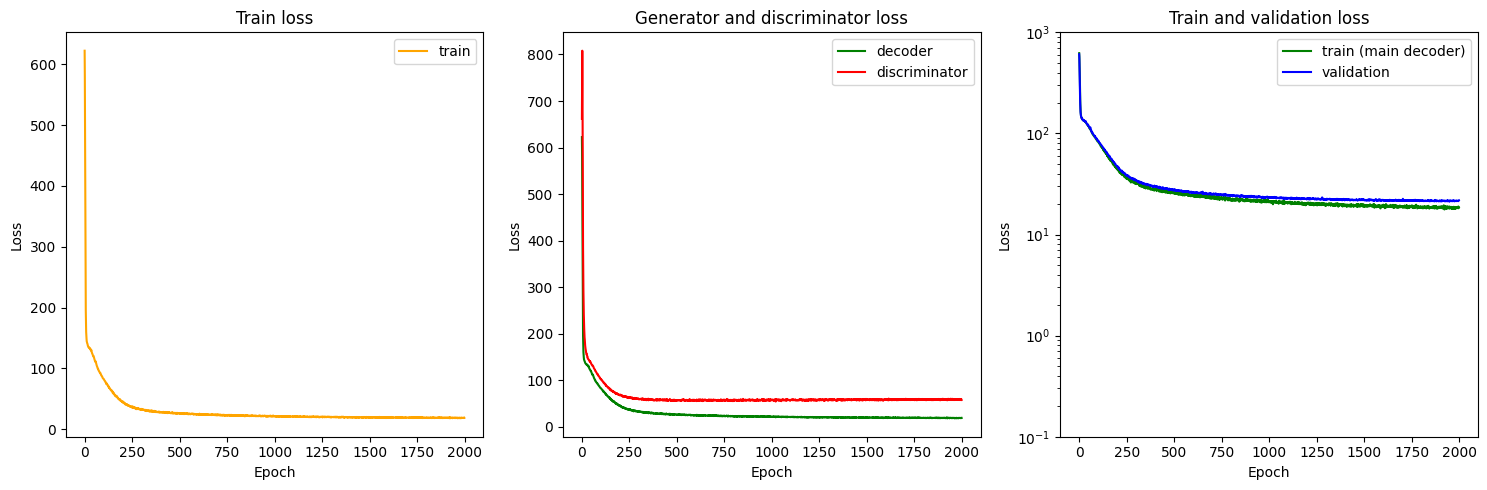

In [9]:
# without anything for reference

encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=dropout_rate).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=1, pretrain=3000)

# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(0.1, 1000)
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

In [10]:
# save encoder, decoder, discriminator_decoder and history
model_name = 'sim2_large_{}-depth_{}-latent_{}-dropout_{}-seed'.format(model_depth, latent_dim, dropout_rate, seed)
model_name += '_epochs2000'

torch.save(encoder.state_dict(), '03_results/models/{}_encoder.pth'.format(model_name))
torch.save(decoder.state_dict(), '03_results/models/{}_decoder.pth'.format(model_name))
history = pd.DataFrame(history)
history.to_csv('03_results/models/{}_history.csv'.format(model_name), index=False)

100%|██████████| 1000/1000 [17:39<00:00,  1.06s/it]


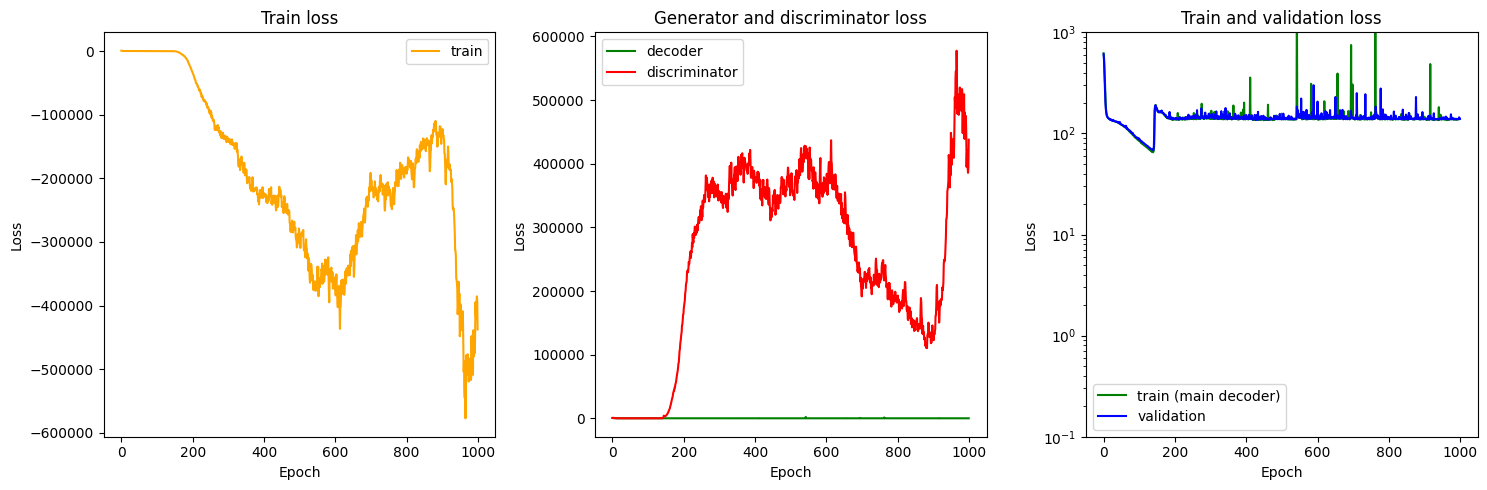

In [6]:
# with pretraining

encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=dropout_rate).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=1000, warmup_steps=500, pretrain=100)

# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(0.1, 1000)
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 1000/1000 [16:07<00:00,  1.03it/s]


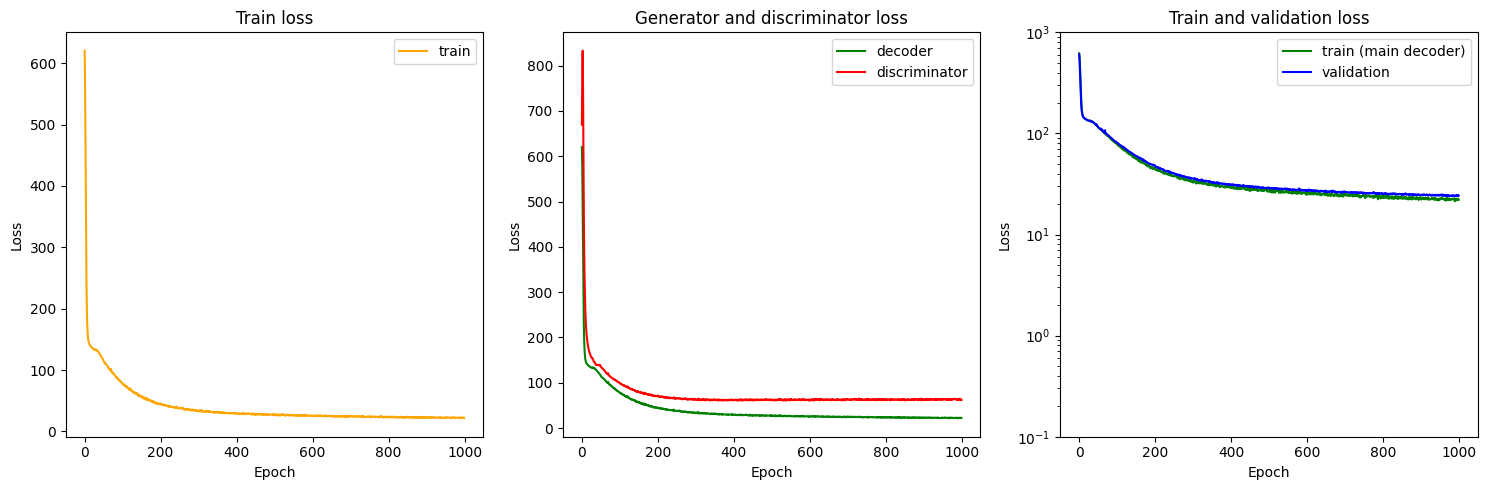

In [5]:
# with pretraining

encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=1000, warmup_steps=500, pretrain=100, beta_max=1e-3)

# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(0.1, 1000)
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 1000/1000 [15:54<00:00,  1.05it/s]


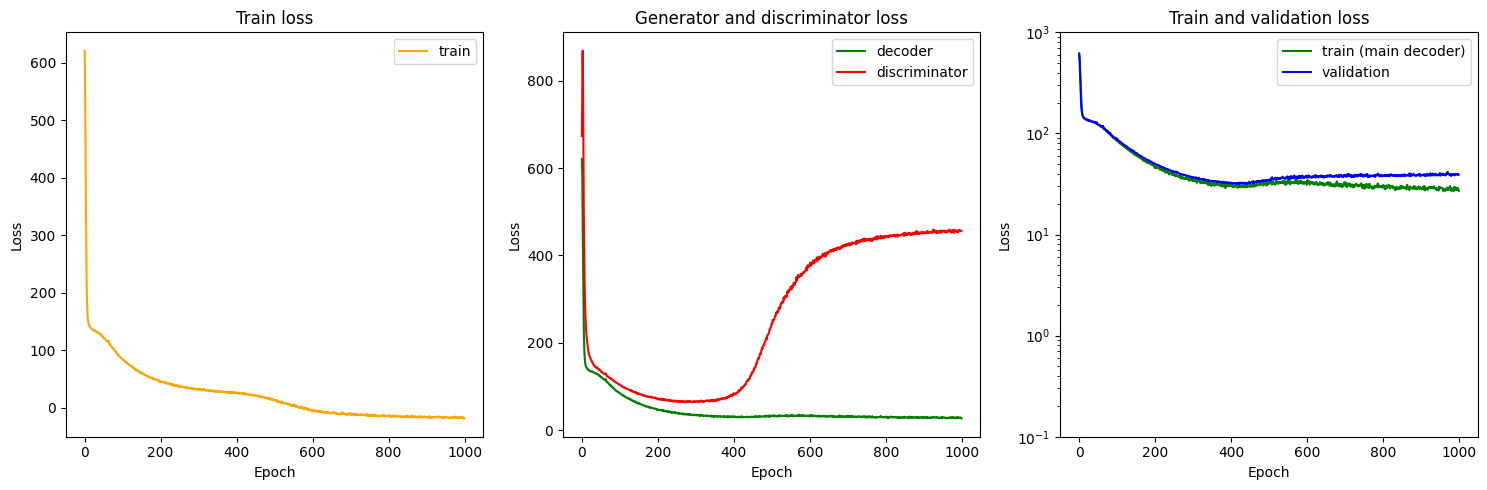

In [6]:
# with pretraining

encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=1000, warmup_steps=500, pretrain=100, beta_max=1e-1)

# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(0.1, 1000)
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 5000/5000 [1:19:16<00:00,  1.05it/s]


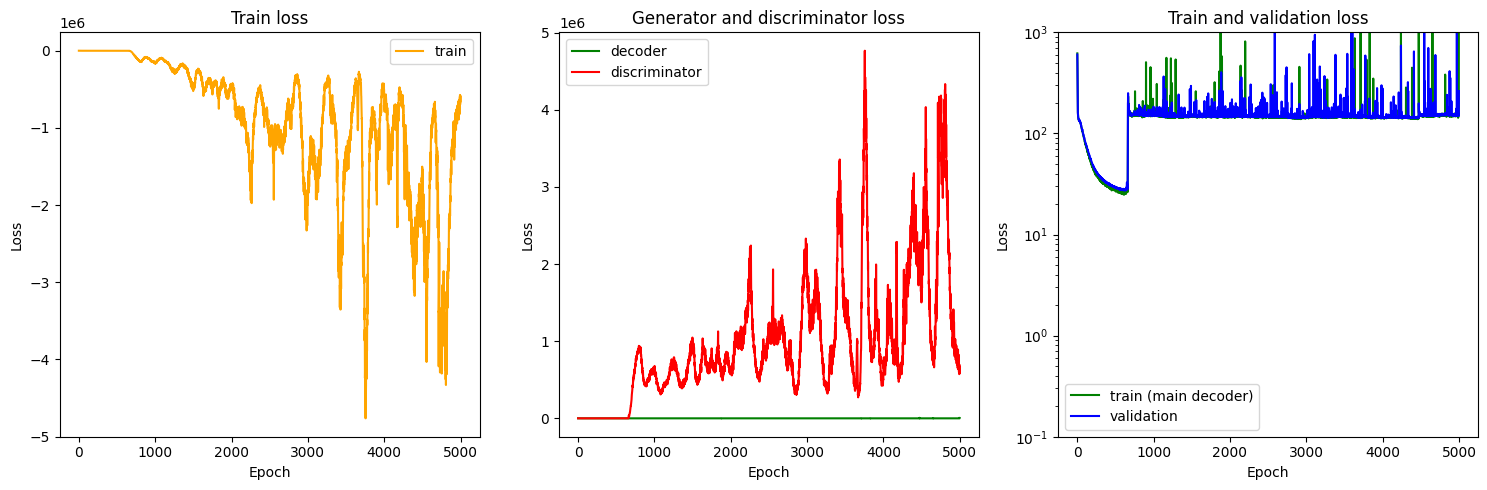

In [7]:
# with pretraining

encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=5000, warmup_steps=2000, pretrain=500, beta_max=1)

# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(0.1, 1000)
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 2000/2000 [31:54<00:00,  1.04it/s]


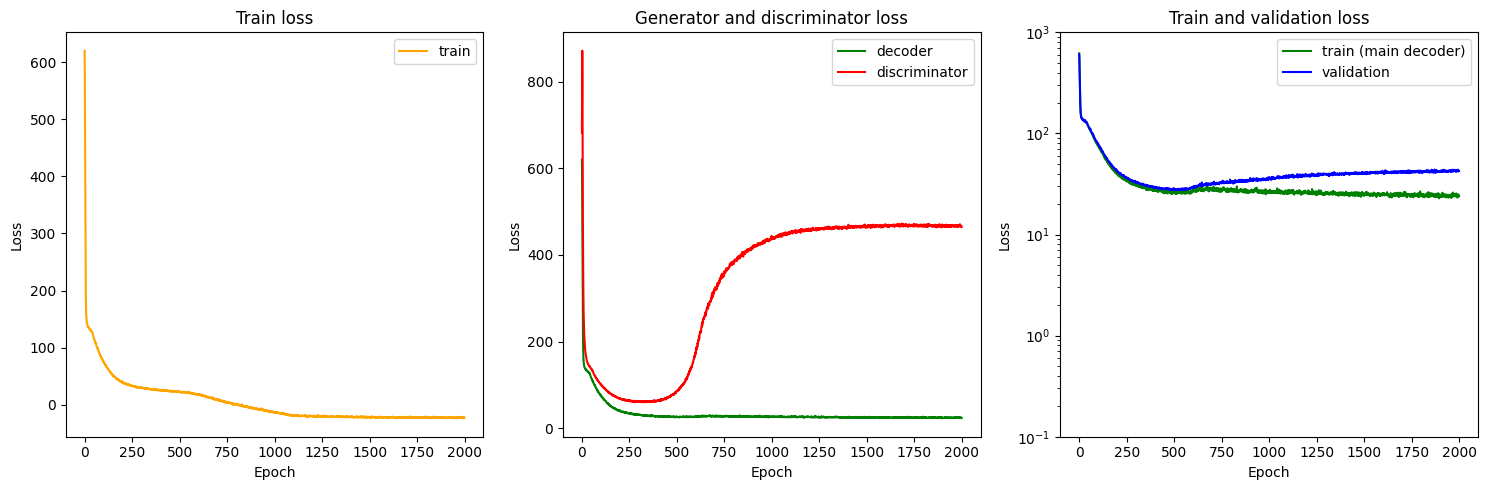

In [8]:
# with pretraining

encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=1000, pretrain=100, beta_max=0.1)

# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(0.1, 1000)
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

In [10]:
# save encoder, decoder, discriminator_decoder and history
model_name = 'sim2_large_{}-depth_{}-latent_{}-dropout_{}-seed'.format(model_depth, latent_dim, dropout_rate, seed)
model_name += '_pretrain_100-warmup_1000-beta_max_1e-1_epochs2000'

torch.save(encoder.state_dict(), '03_results/models/{}_encoder.pth'.format(model_name))
torch.save(decoder.state_dict(), '03_results/models/{}_decoder.pth'.format(model_name))
torch.save(discriminator_decoder.state_dict(), '03_results/models/{}_discriminator.pth'.format(model_name))
history = pd.DataFrame(history)
history.to_csv('03_results/models/{}_history.csv'.format(model_name), index=False)

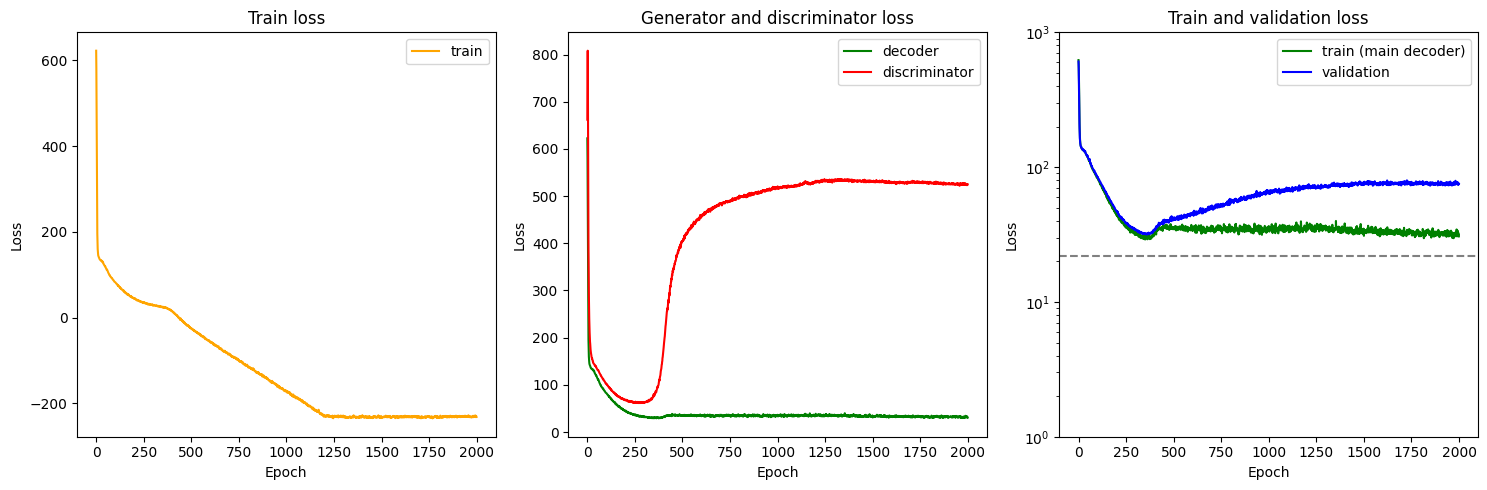

In [ ]:
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=1000, pretrain=200, beta_max=0.5)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

In [7]:
# save encoder, decoder, discriminator_decoder and history
model_name = 'sim2_large_{}-depth_{}-latent_{}-dropout_{}-seed'.format(model_depth, latent_dim, dropout_rate, seed)
model_name += '_pretrain_200-warmup_1000-beta_max_5e-1_epochs2000'

torch.save(encoder.state_dict(), '03_results/models/{}_encoder.pth'.format(model_name))
torch.save(decoder.state_dict(), '03_results/models/{}_decoder.pth'.format(model_name))
torch.save(discriminator_decoder.state_dict(), '03_results/models/{}_discriminator.pth'.format(model_name))
history = pd.DataFrame(history)
history.to_csv('03_results/models/{}_history.csv'.format(model_name), index=False)

100%|██████████| 2000/2000 [34:11<00:00,  1.03s/it]


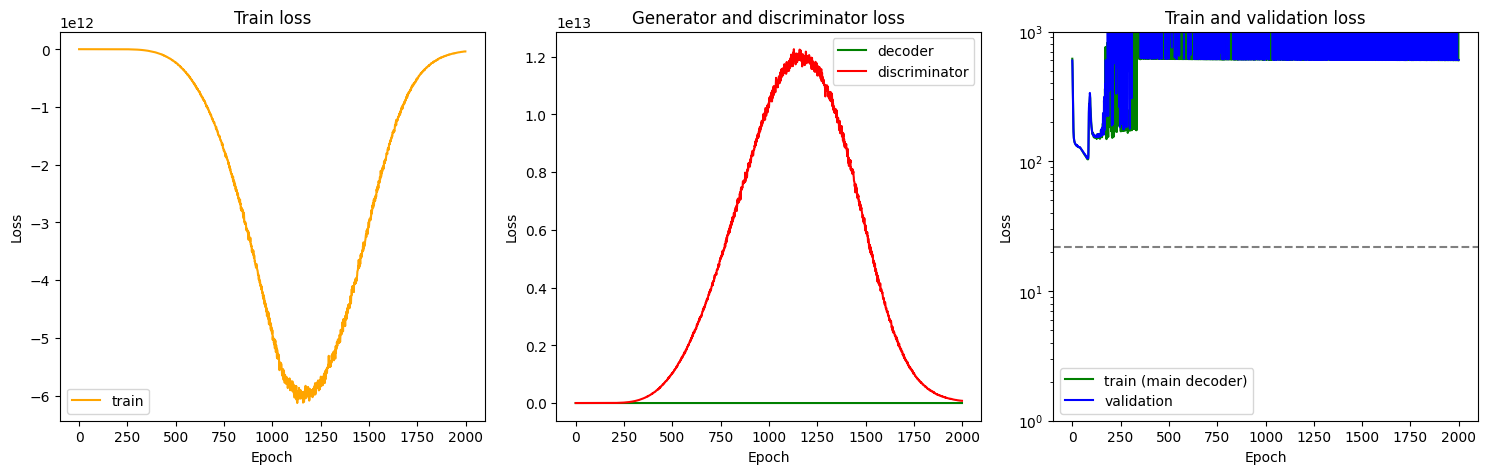

In [ ]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=1000, pretrain=50, beta_max=0.5)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 2000/2000 [34:17<00:00,  1.03s/it]


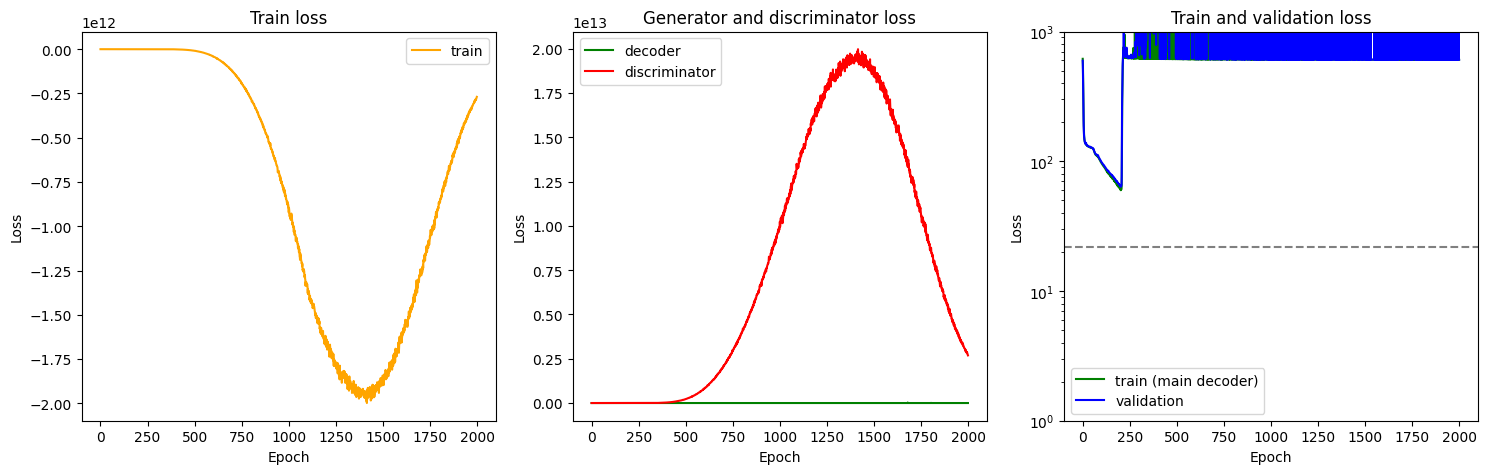

In [9]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=1000, pretrain=100, beta_max=0.1)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 2000/2000 [33:40<00:00,  1.01s/it]


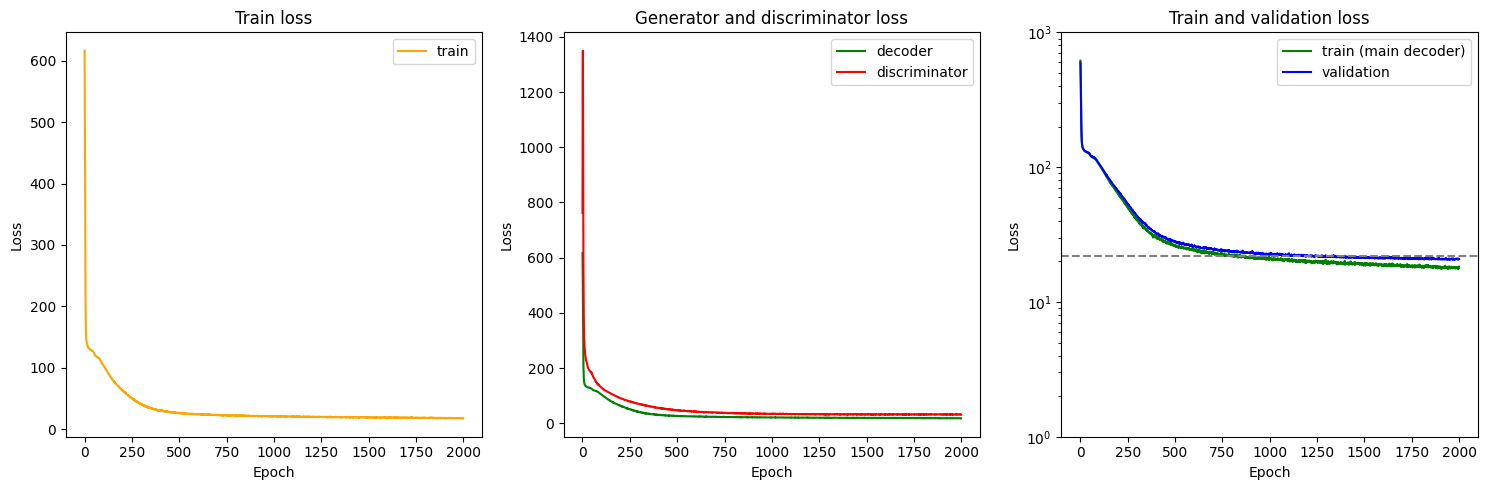

In [10]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=2000, pretrain=2000, beta_max=0.1)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 2000/2000 [34:11<00:00,  1.03s/it]


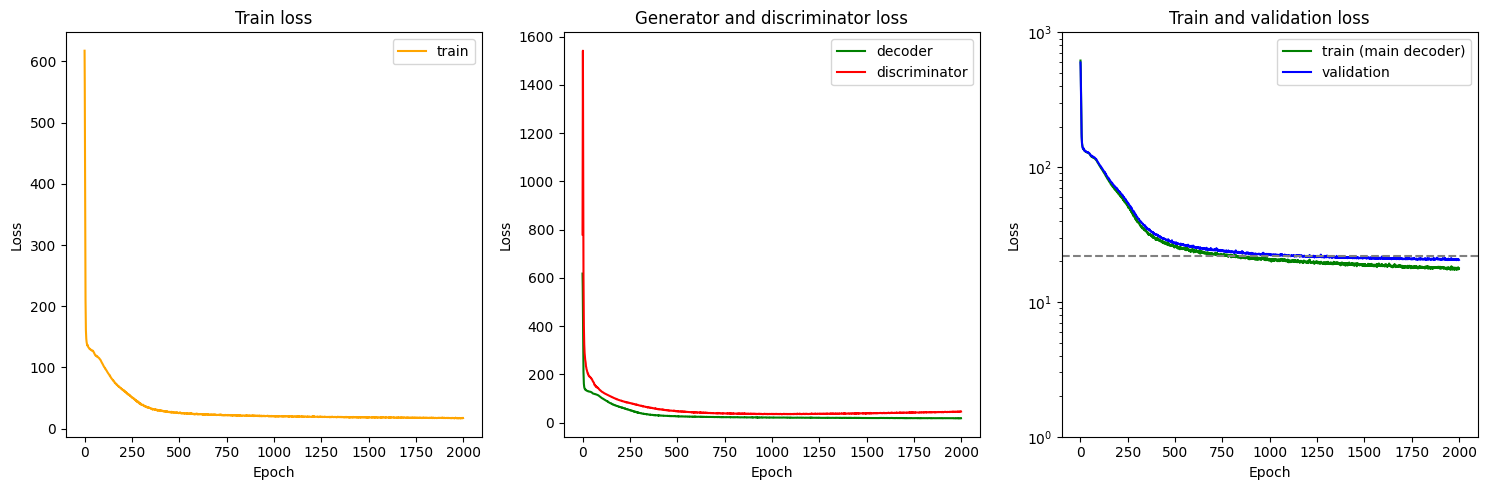

In [4]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=1000, pretrain=200, beta_max=1e-2)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 2000/2000 [34:10<00:00,  1.03s/it]


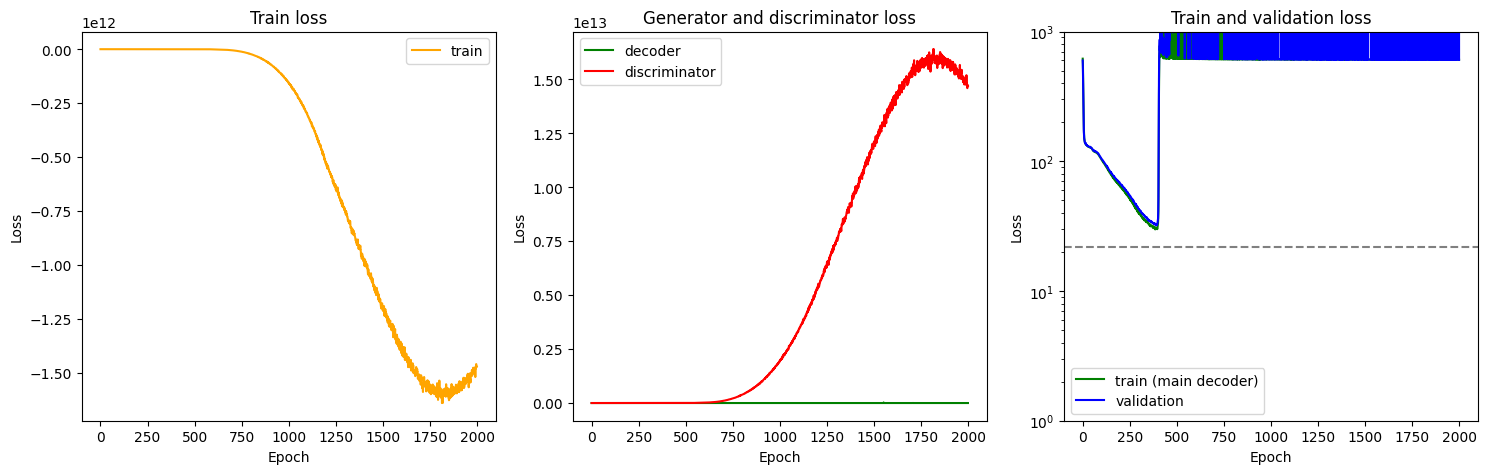

In [4]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=1000, pretrain=200, beta_max=1e-1)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 2000/2000 [48:56<00:00,  1.47s/it]    


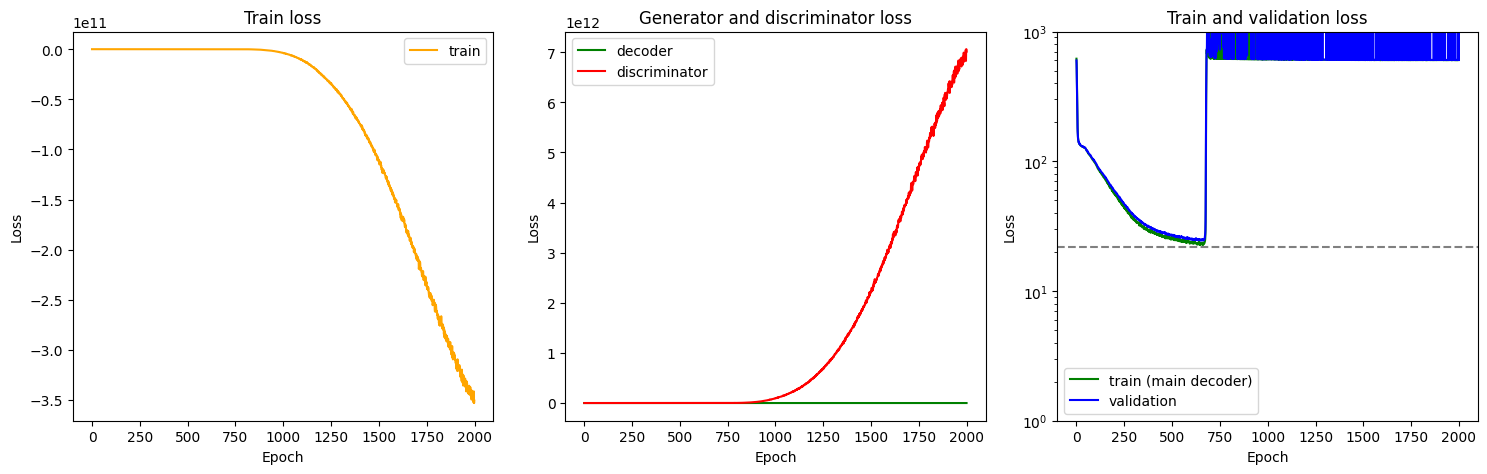

In [ ]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=1000, pretrain=200, beta_max=5e-2)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 2000/2000 [34:27<00:00,  1.03s/it]


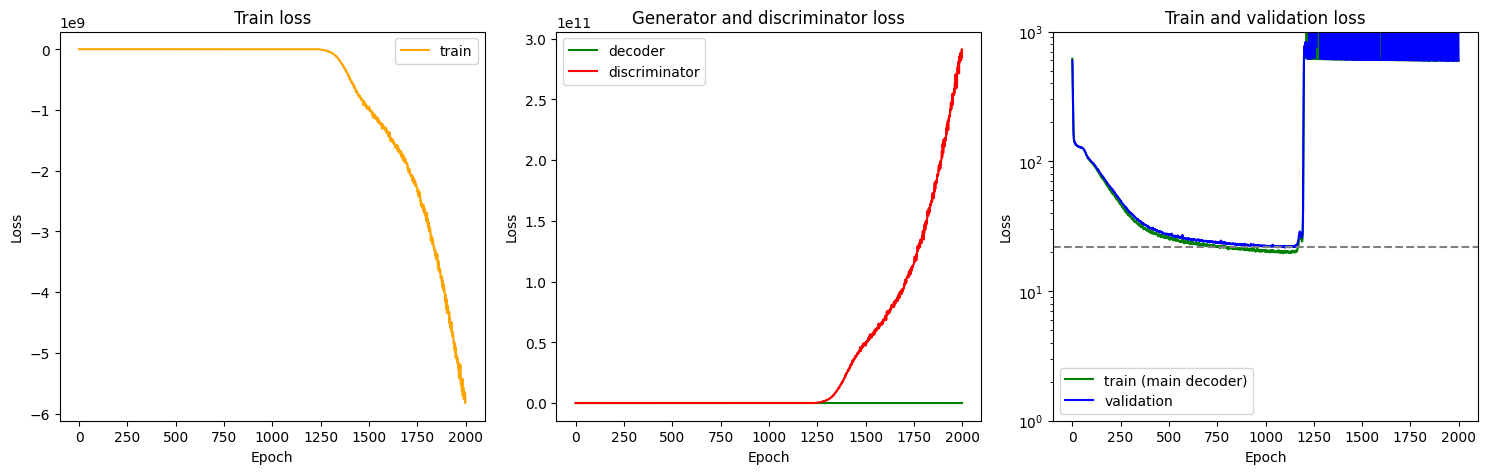

In [6]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=1000, pretrain=200, beta_max=2e-2)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 2000/2000 [35:32<00:00,  1.07s/it]


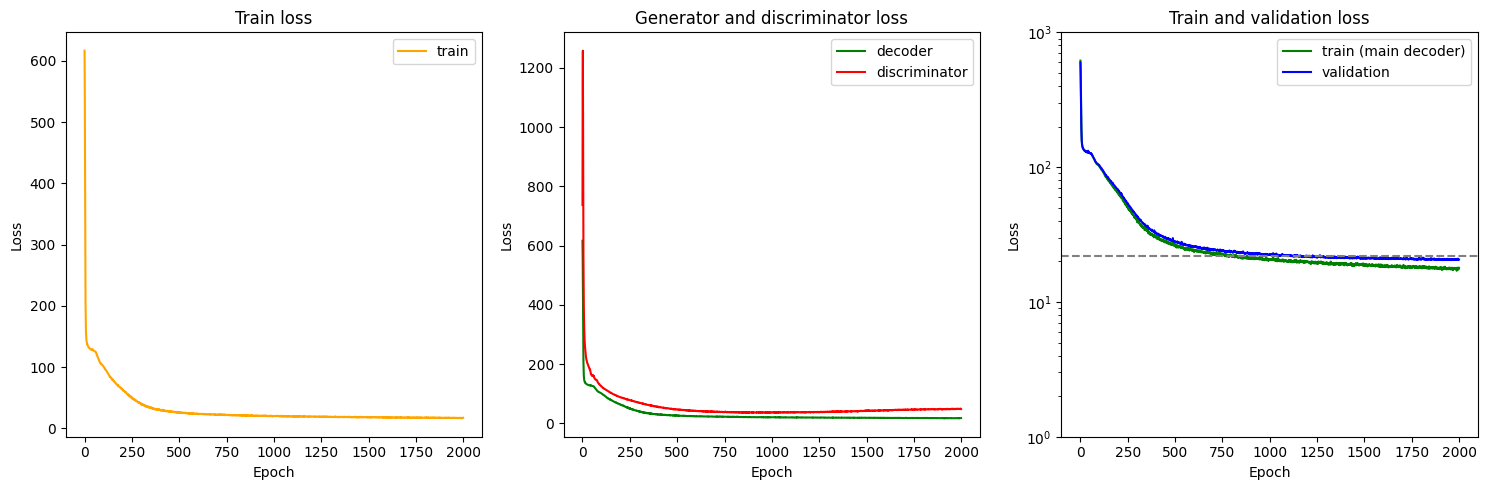

In [7]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=1000, pretrain=10, beta_max=1e-2)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 500/500 [08:33<00:00,  1.03s/it]


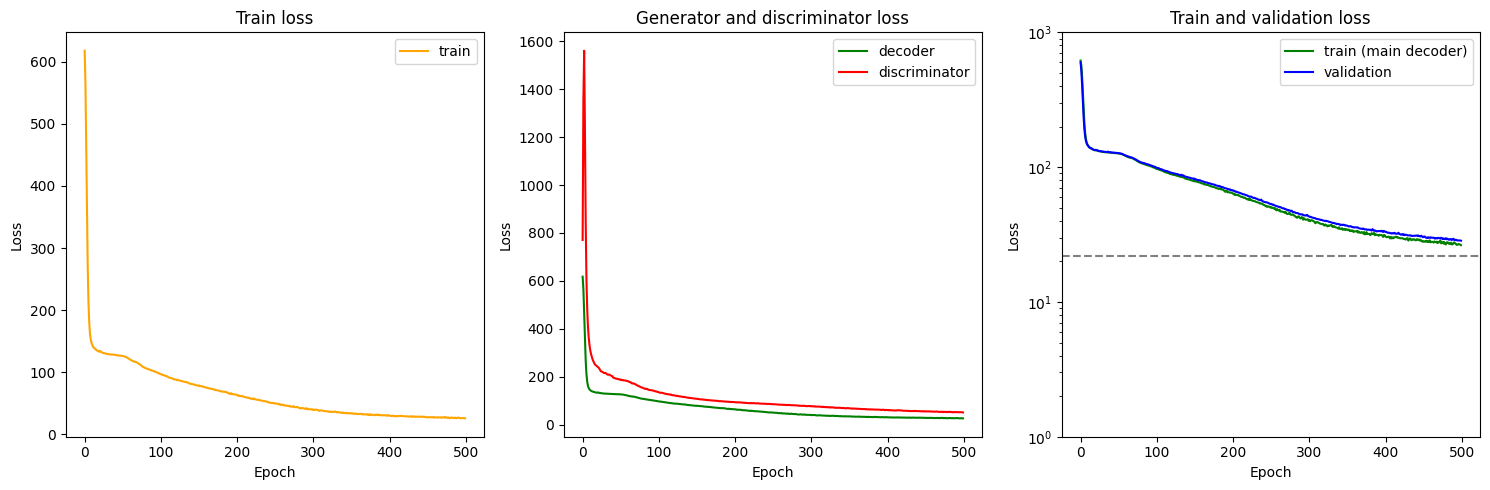

In [8]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=500, warmup_steps=1000, pretrain=10, beta_max=2e-2)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 500/500 [08:56<00:00,  1.07s/it]


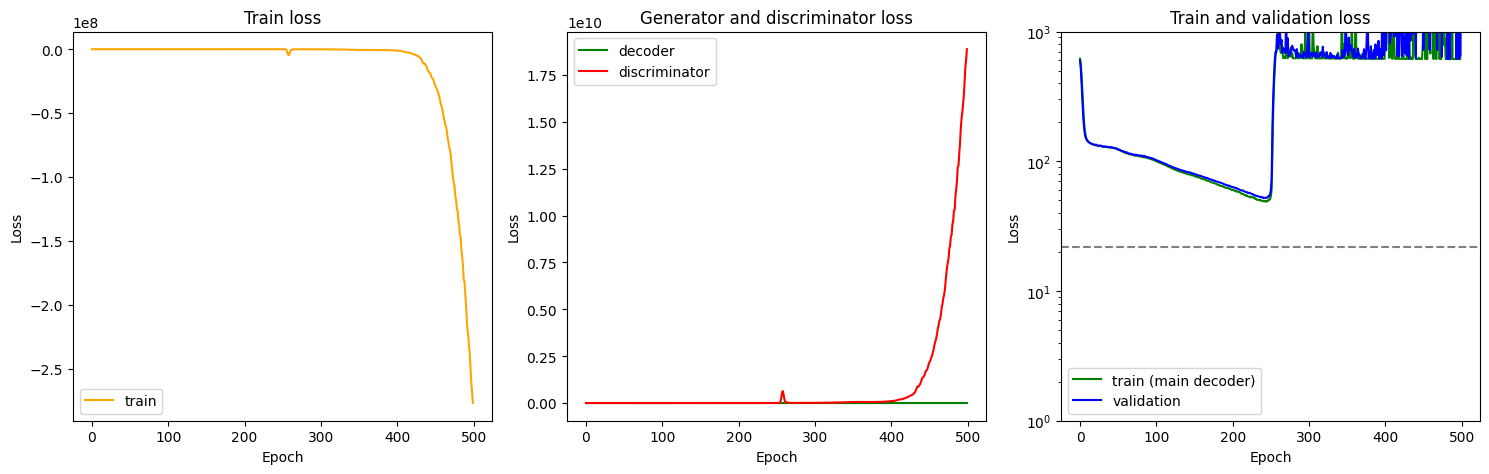

In [11]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=500, warmup_steps=1000, pretrain=10, beta_max=3e-2)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 500/500 [08:36<00:00,  1.03s/it]


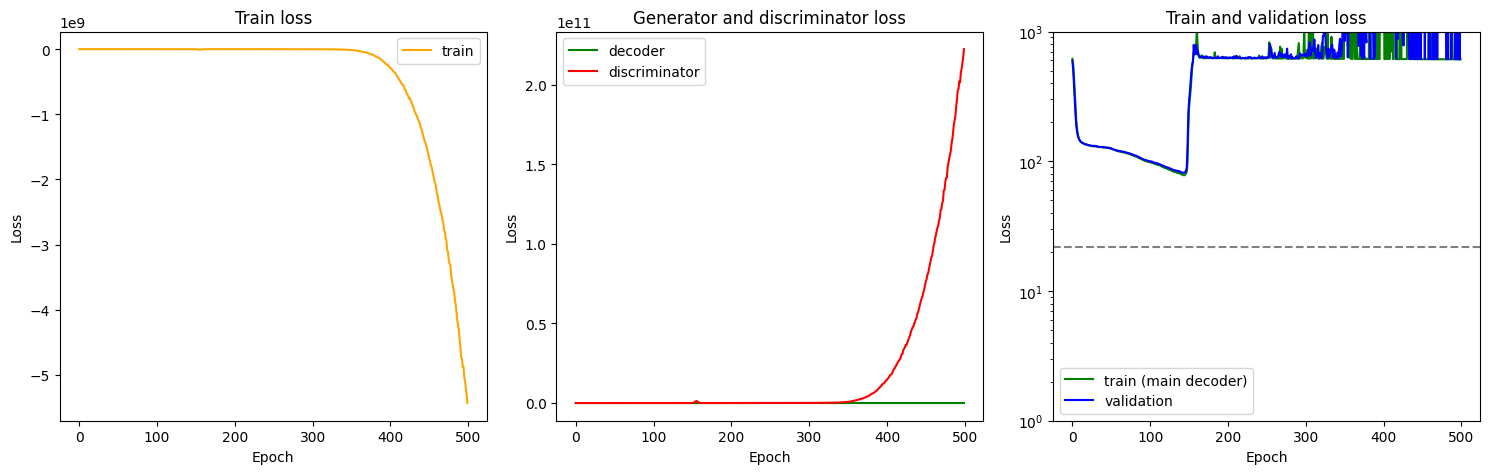

In [10]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=500, warmup_steps=1000, pretrain=10, beta_max=5e-2)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 500/500 [08:39<00:00,  1.04s/it]


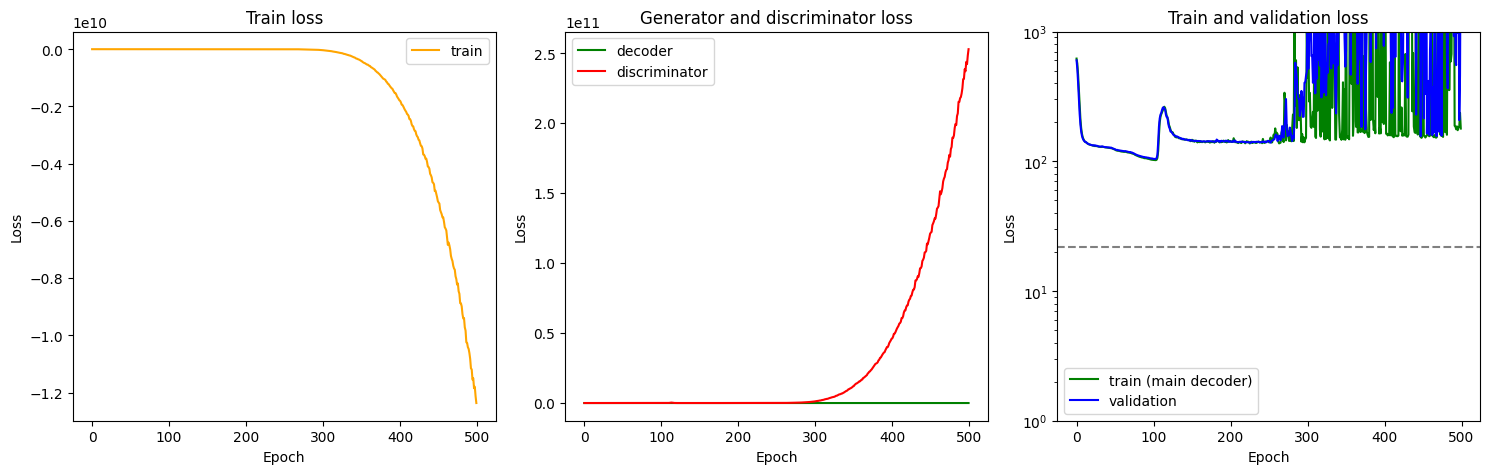

In [9]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=500, warmup_steps=1000, pretrain=10, beta_max=1e-1)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 2000/2000 [45:34<00:00,  1.37s/it]


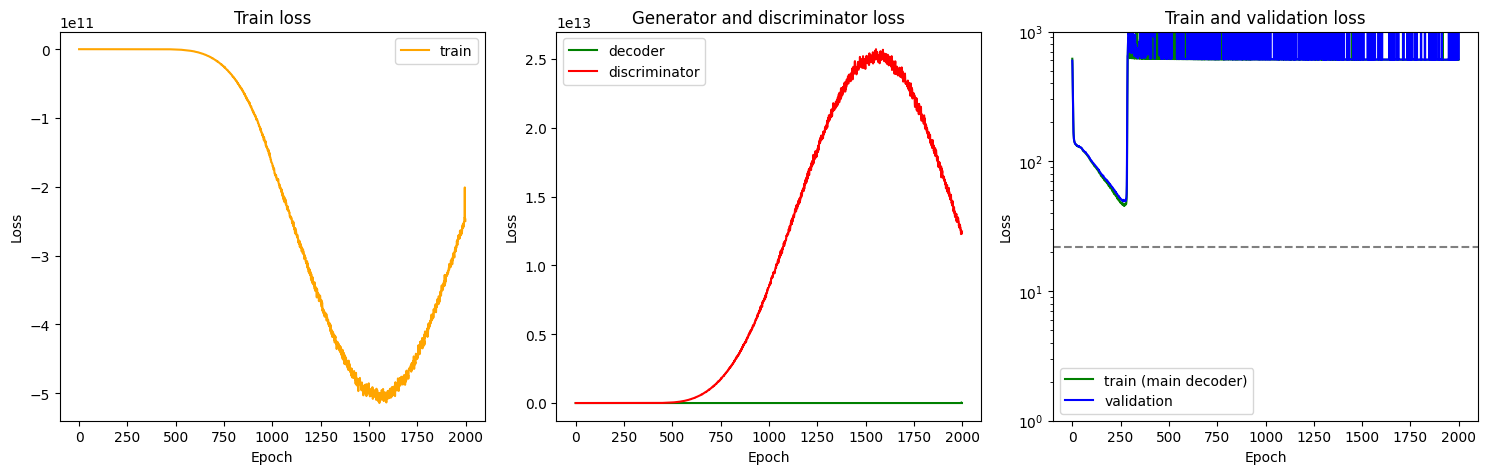

In [12]:
model_depth = 3
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=2000, warmup_steps=1000, pretrain=10, beta_max=2e-2)


# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(1, 1000)
# put a line at the baseline val loss
ax[2].axhline(y=baseline_val_loss, color='gray', linestyle='--')
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

### normalized losses with R2 for adversarial loss

100%|██████████| 500/500 [08:42<00:00,  1.05s/it]


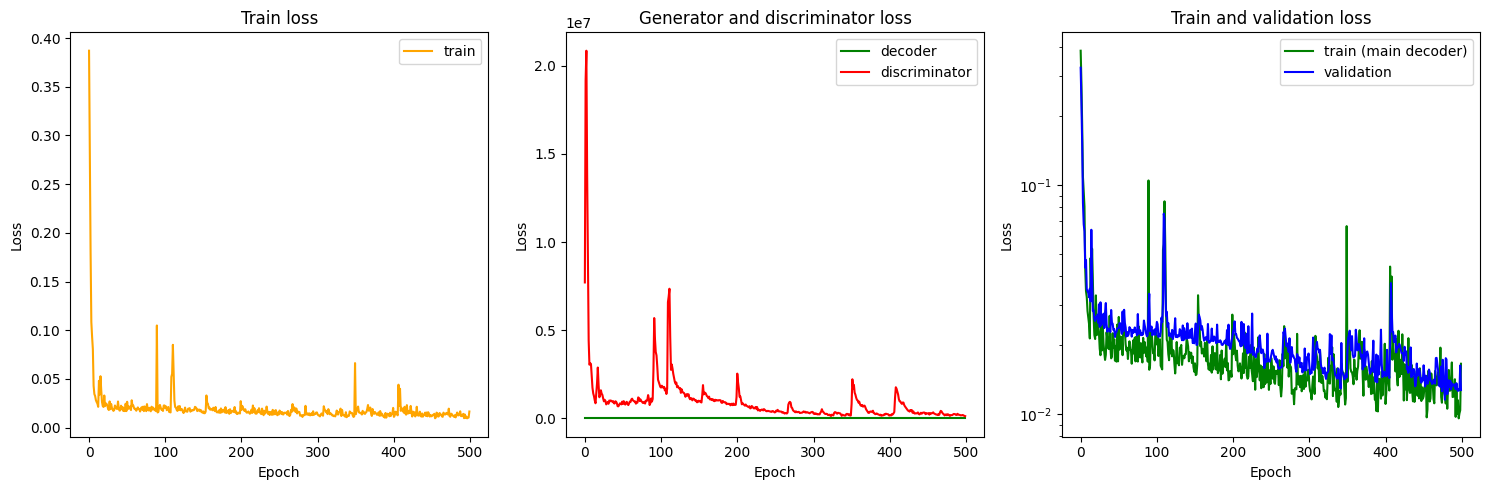

In [4]:
# with pretraining

model_depth = 2
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=500, warmup_steps=1000, pretrain=2001, beta_max=0.1, adversarial_scheme='r2')

# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
#ax[2].set_ylim(0.1, 1000)
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

100%|██████████| 500/500 [09:07<00:00,  1.10s/it]


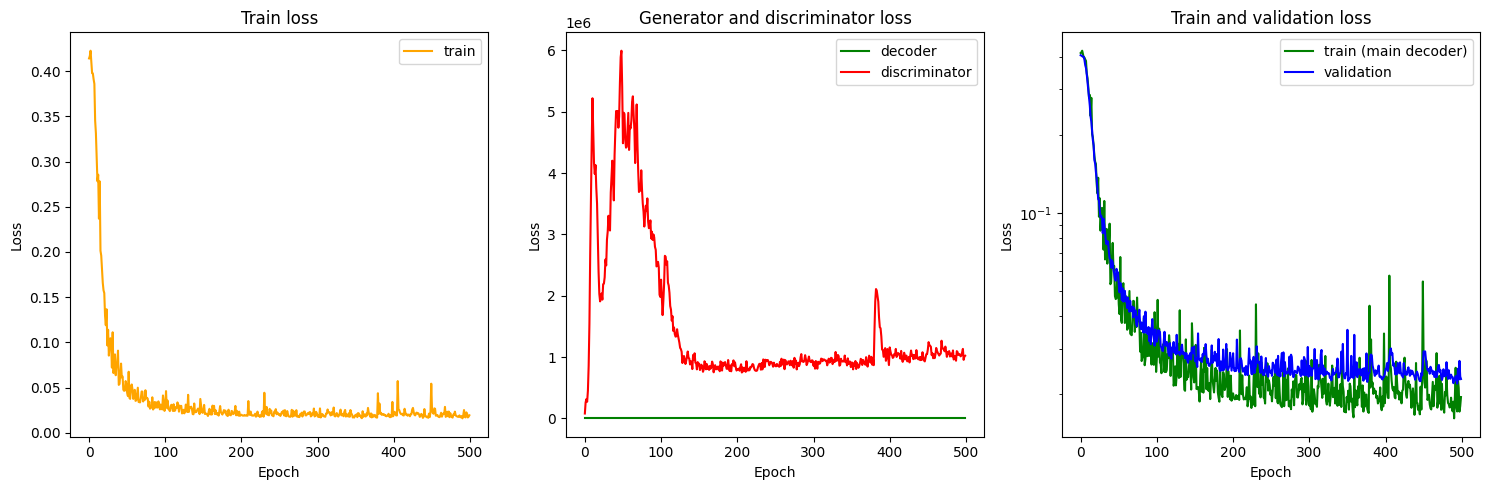

In [5]:
# with pretraining

model_depth = 2
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=500, warmup_steps=1000, pretrain=2001, 
    learning_rate=1e-5, beta_max=0.1, adversarial_scheme='r2')

# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
#ax[2].set_ylim(0.1, 1000)
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

In [4]:
# with pretraining

model_depth = 2
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=1, warmup_steps=1000, pretrain=2001, beta_max=0.1, adversarial_scheme='r2')

history

  0%|          | 0/1 [00:00<?, ?it/s]

tensor(136805.4844, grad_fn=<MeanBackward0>)
tensor(0.4067, grad_fn=<MeanBackward0>)
tensor(130013.2109, grad_fn=<MeanBackward0>)
tensor(732070.6250, grad_fn=<MeanBackward0>)
tensor(0.4539, grad_fn=<MeanBackward0>)
tensor(741088.1250, grad_fn=<MeanBackward0>)
tensor(2343890., grad_fn=<MeanBackward0>)
tensor(0.3828, grad_fn=<MeanBackward0>)
tensor(2473340., grad_fn=<MeanBackward0>)
tensor(5886466.5000, grad_fn=<MeanBackward0>)
tensor(0.3936, grad_fn=<MeanBackward0>)
tensor(5644558.5000, grad_fn=<MeanBackward0>)
tensor(9655339., grad_fn=<MeanBackward0>)
tensor(0.3629, grad_fn=<MeanBackward0>)
tensor(9132410., grad_fn=<MeanBackward0>)
tensor(12712682., grad_fn=<MeanBackward0>)
tensor(0.3044, grad_fn=<MeanBackward0>)
tensor(12545854., grad_fn=<MeanBackward0>)
tensor(15327781., grad_fn=<MeanBackward0>)
tensor(0.4698, grad_fn=<MeanBackward0>)
tensor(16072714., grad_fn=<MeanBackward0>)
tensor(14760806., grad_fn=<MeanBackward0>)
tensor(0.3222, grad_fn=<MeanBackward0>)
tensor(14922819., grad_fn

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


,train_loss,g_loss,d_loss,val_loss,epoch
0,0.38704,0.38704,7.707850e+06,0.326277,0


100%|██████████| 500/500 [08:52<00:00,  1.06s/it]


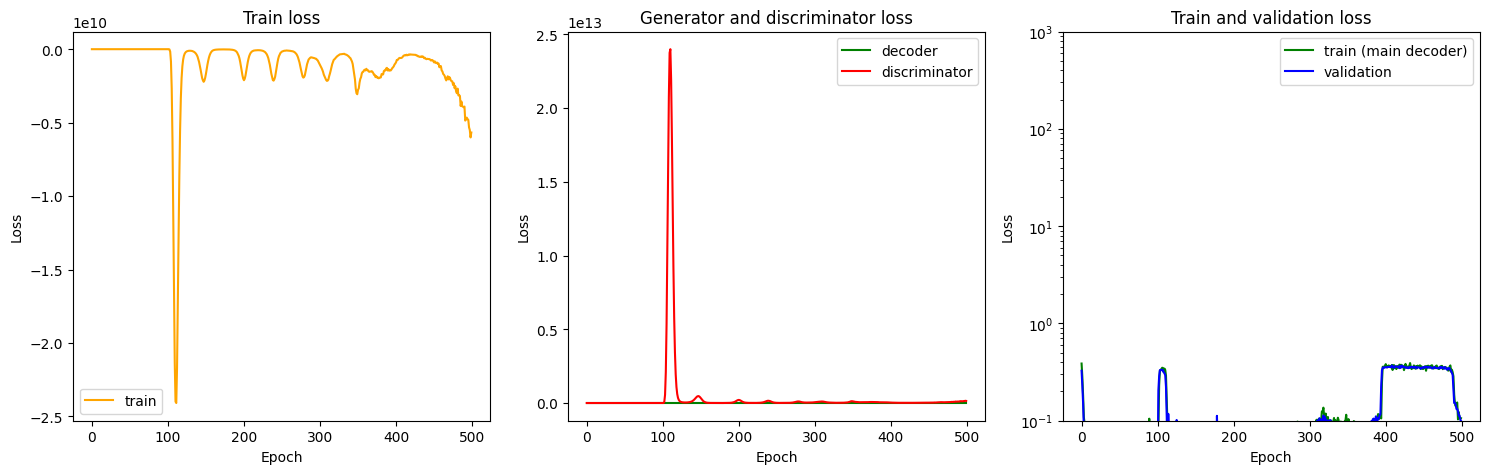

In [4]:
# with pretraining

model_depth = 2
encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)
discriminator_decoder = Decoder(latent_dim, 20000, 1, dropout=0).to(device)

encoder, decoder, discriminator_decoder, history = train_and_eval_model2(
    encoder, decoder, discriminator_decoder, 
    rna_counts, n_samples, n_samples_validation, 
    n_epochs=500, warmup_steps=1000, pretrain=100, beta_max=0.1, adversarial_scheme='r2')

# plot the history
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='train', color='orange')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(history['g_loss'], label='decoder', color='green')
ax[1].plot(history['d_loss'], label='discriminator', color='red')
ax[1].set_title('Generator and discriminator loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[2].plot(history['g_loss'], label='train (main decoder)', color='green')
ax[2].plot(history['val_loss'], label='validation', color='blue')
ax[2].set_yscale('log')
ax[2].set_ylim(0.1, 1000)
ax[2].set_title('Train and validation loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
plt.tight_layout()

## Find the superpositions and fits

In [4]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

def identify_superpositions(r, y):
    #reg_coeffs_reps = np.zeros((y.shape[0], r.shape[1]))
    reg_coeffs_reps = np.zeros((y.shape[1], r.shape[1]))
    reg_fits_reps = np.zeros(y.shape[1])

    for i in tqdm(range(y.shape[1])):
        reg = LinearRegression().fit(r, y[:, i])
        reg_fits_reps[i] = reg.score(r, y[:, i])
        reg_coeffs_reps[i,:] = reg.coef_
    
    return reg_coeffs_reps, reg_fits_reps

In [8]:
for seed in range(1):
    temp_y = torch.load(data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed), weights_only=False)
    temp_x0 = torch.load(data_dir+'large_{}-complexity_rs{}_x0.pt'.format(complexity, seed), weights_only=False)
    temp_x1 = torch.load(data_dir+'large_{}-complexity_rs{}_x1.pt'.format(complexity, seed), weights_only=False)
    temp_x2 = torch.load(data_dir+'large_{}-complexity_rs{}_x2.pt'.format(complexity, seed), weights_only=False)
    temp_ct = torch.load(data_dir+'large_{}-complexity_rs{}_ct.pt'.format(complexity, seed), weights_only=False)
    temp_cov = torch.load(data_dir+'large_{}-complexity_rs{}_co.pt'.format(complexity, seed), weights_only=False)
    if seed == 0:
        rna_counts = temp_y
        x0 = temp_x0
        x1 = temp_x1
        x2 = temp_x2
        ct = temp_ct
        co = temp_cov
    else:
        rna_counts = torch.cat((rna_counts, temp_y), dim=0)
        x0 = torch.cat((x0, temp_x0), dim=0)
        x1 = torch.cat((x1, temp_x1), dim=0)
        x2 = torch.cat((x2, temp_x2), dim=0)
        ct = torch.cat((ct, temp_ct), dim=0)
        co = torch.cat((co, temp_cov), dim=0)
# limit to the training data
n_samples_validation = int(n_samples*0.1)
rna_counts = rna_counts[:n_samples]
x0 = x0[:n_samples]
x1 = x1[:n_samples]
x2 = x2[:n_samples]
ct = ct[:n_samples]
co = co[:n_samples]

### redo baseline for small data and short training

In [9]:
model_name = 'sim2_large_{}-depth_{}-latent_{}-dropout_{}-seed'.format(model_depth, latent_dim, dropout_rate, seed)
model_name += '_epochs2000'

if not os.path.exists('03_results/models/'+model_name+'_rep.pth'):
    reps = encoder(rna_counts).detach().cpu()
    torch.save(reps, '03_results/models/'+model_name+'_rep.pth')
else:
    reps = torch.load('03_results/models/'+model_name+'_rep.pth', weights_only=False)

In [10]:
if not os.path.exists('03_results/models/'+model_name+'_y_coeffs.npy'):
    y_coeffs, y_fits = identify_superpositions(reps.cpu().detach().numpy(), rna_counts.cpu().detach().numpy())

    # save the results
    np.save('03_results/models/'+model_name+'_y_coeffs.npy', y_coeffs)
    np.save('03_results/models/'+model_name+'_y_fits.npy', y_fits)
else:
    y_coeffs = np.load('03_results/models/'+model_name+'_y_coeffs.npy')
    y_fits = np.load('03_results/models/'+model_name+'_y_fits.npy')

x0_coeffs, x0_fits = identify_superpositions(reps.cpu().detach().numpy(), x0.cpu().detach().numpy())
x1_coeffs, x1_fits = identify_superpositions(reps.cpu().detach().numpy(), x1.cpu().detach().numpy())
x2_coeffs, x2_fits = identify_superpositions(reps.cpu().detach().numpy(), x2.cpu().detach().numpy())
ct_coeffs, ct_fits = identify_superpositions(reps.cpu().detach().numpy(), ct.unsqueeze(1).cpu().detach().numpy())
co_coeffs, co_fits = identify_superpositions(reps.cpu().detach().numpy(), co.unsqueeze(1).cpu().detach().numpy())

coeff_names = ['y']*y_coeffs.shape[0] + ['x0']*x0_coeffs.shape[0] + ['x1']*x1_coeffs.shape[0] + ['x2']*x2_coeffs.shape[0] + ['ct'] + ['co']

all_fits = np.concatenate((y_fits, x0_fits, x1_fits, x2_fits, ct_fits, co_fits), axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


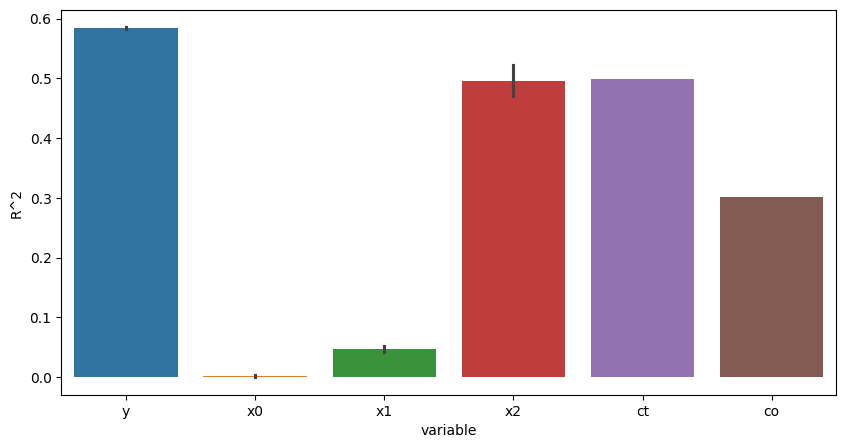

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.barplot(x=coeff_names, y=all_fits, hue=coeff_names, ax=ax)
plt.ylabel('R^2')
plt.xlabel('variable')
plt.show()

### test adversarial: pretrain 100, warmup 1000, beta 0.1

In [12]:
model_name = 'sim2_large_{}-depth_{}-latent_{}-dropout_{}-seed'.format(model_depth, latent_dim, dropout_rate, seed)
model_name += '_pretrain_100-warmup_1000-beta_max_1e-1_epochs2000'


if not os.path.exists('03_results/models/'+model_name+'_rep.pth'):
    reps = encoder(rna_counts).detach().cpu()
    torch.save(reps, '03_results/models/'+model_name+'_rep.pth')
else:
    reps = torch.load('03_results/models/'+model_name+'_rep.pth', weights_only=False)

In [13]:
if not os.path.exists('03_results/models/'+model_name+'_y_coeffs.npy'):
    y_coeffs, y_fits = identify_superpositions(reps.cpu().detach().numpy(), rna_counts.cpu().detach().numpy())

    # save the results
    np.save('03_results/models/'+model_name+'_y_coeffs.npy', y_coeffs)
    np.save('03_results/models/'+model_name+'_y_fits.npy', y_fits)
else:
    y_coeffs = np.load('03_results/models/'+model_name+'_y_coeffs.npy')
    y_fits = np.load('03_results/models/'+model_name+'_y_fits.npy')

x0_coeffs, x0_fits = identify_superpositions(reps.cpu().detach().numpy(), x0.cpu().detach().numpy())
x1_coeffs, x1_fits = identify_superpositions(reps.cpu().detach().numpy(), x1.cpu().detach().numpy())
x2_coeffs, x2_fits = identify_superpositions(reps.cpu().detach().numpy(), x2.cpu().detach().numpy())
ct_coeffs, ct_fits = identify_superpositions(reps.cpu().detach().numpy(), ct.unsqueeze(1).cpu().detach().numpy())
co_coeffs, co_fits = identify_superpositions(reps.cpu().detach().numpy(), co.unsqueeze(1).cpu().detach().numpy())

coeff_names = ['y']*y_coeffs.shape[0] + ['x0']*x0_coeffs.shape[0] + ['x1']*x1_coeffs.shape[0] + ['x2']*x2_coeffs.shape[0] + ['ct'] + ['co']

all_fits = np.concatenate((y_fits, x0_fits, x1_fits, x2_fits, ct_fits, co_fits), axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


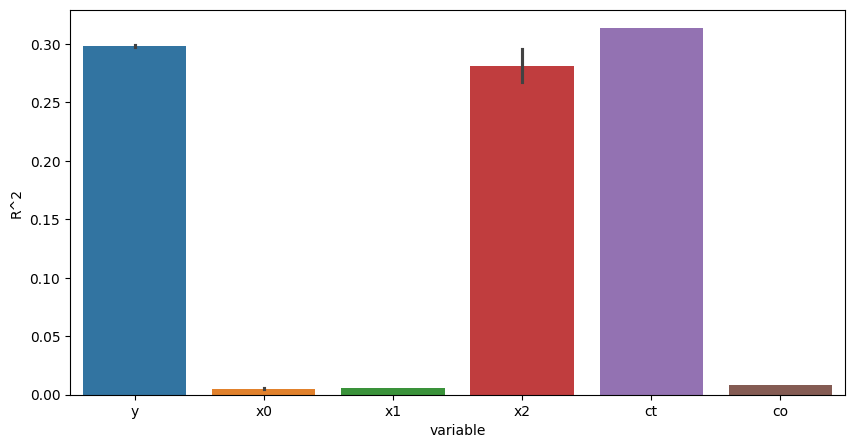

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.barplot(x=coeff_names, y=all_fits, hue=coeff_names, ax=ax)
plt.ylabel('R^2')
plt.xlabel('variable')
plt.show()